### Ideias

* Podemos ter uma segunda avaliação com peso de acordo com os trendings e seus direcionamentos para sentimento... ele pode aumentar ou diminuir o peso do sentimento...
* Vamos usar comitês para tentar melhorar?
* Trending tentaremos obter palavras dos ngrams? E incluí-las? Além do tratamento de trending e sentimento
* We highly recommend the twokenize tokenizer from Allen Ritter’s work (https://github.com/aritter/twitter_nlp/blob/master/python/twokenize.py)

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re,string,unicodedata
from collections import Counter

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.models import model_from_json
from keras.models import load_model

from sklearn.model_selection import train_test_split

import seaborn as sns

import contractions 

## Inicializações

#### NLTK

In [2]:
nltk.download()
nltk.download('stopwords')

lista_stopwords = set(stopwords.words('english'))
punctuation = list(string.punctuation)
lista_stopwords.update(punctuation)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gdutr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
ARQUIVO_GLOVE_100 = 'glove.6B.100d.txt'
ARQUIVO_GLOVE_100_TWITTER = 'glove.twitter.27B.100d.txt'

## Funções

#### Utilitários

In [4]:
# Carrega o arquivo de Embeddings
def read_embedding(file_name):
    with open(file_name,'r', encoding="utf8") as f:
        word_vocab = {} 
        word2vector = []
        pos = 0
        for line in f:
            line_ = line.strip() 
            words_vec = line_.split()
            
            if (len(words_vec) == 101):
                word_vocab[words_vec[0]] = pos
                word2vector.append(np.array(words_vec[1:],dtype=float)) 
                pos+=1
            
    word2vector = np.stack(word2vector)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

#### Limpeza dos Dados

In [5]:
def limpa_texto(texto):
    # link
    texto = re.sub('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', texto)
    # numero string com números não estamos retirando inicialmente (COVID-19)
    texto = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', '', texto)
    texto = re.sub(r'\s+', ' ', texto)
    return texto

In [6]:
#Labels. Pemite agrupar negativos e positivos
def get_labels_dict(agrupar_labels):
    if not agrupar_labels:
        return {'Extremely Negative': -2 , 'Negative': -1, 'Neutral': 0, 'Positive': 1, 'Extremely Positive': 2}
    else:
        return {'Negative': -1 ,'Neutral': 0, 'Positive': 1}    
    
    
# Converter labels da representação textual para one hot encode
def convert_labels_to_hot_encode(labels, labels_dict):
    labels_conv =[labels_dict[label] for label in labels]
    return pd.get_dummies(labels_conv).to_numpy()

---

## Pré-Processamento

### Rotina Pré-Processamento (Representação Vetorial/Contexto)

In [7]:
# separa tokens por representação vetorial
def split_tokens_word_vec(texto, vocab, use_twitter_tokenizer, use_lemmatizer, min_length_word):
    lemmatizer = WordNetLemmatizer()
    
    texto = contractions.fix(texto) 
        
    lista_tokens_inicial = []
    if use_twitter_tokenizer:
        t_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
        lista_tokens_inicial = t_tokenizer.tokenize(texto)
    else:
        lista_tokens_inicial = word_tokenize(texto)
    
    tokens_encontrados = []
    tokens_nao_encontrados = []
    
    for token in lista_tokens_inicial:
        add_token = True
        
        token_tratado = token.lower()
        if use_lemmatizer:
            token_tratado = lemmatizer.lemmatize(token)
        
        if token_tratado in lista_stopwords:
            add_token = False
        
        if len(token_tratado) < min_length_word:
            add_token = False
        
        if add_token:
            if token_tratado in vocab:
                tokens_encontrados.append(token_tratado)
            else:
                tokens_nao_encontrados.append(token)
    return tokens_encontrados, tokens_nao_encontrados
        

In [8]:
def carrega_tokens_word_vec(lista_tweet, vocab, use_twitter_tokenizer,  use_lemmatizer, min_length_word):
    feature_tokens = []
    feature_tokens_verificar =[]
    for tweet in lista_tweet:
        texto_limpo = limpa_texto(tweet)
        tokens_add, tokens_verify = split_tokens_word_vec(texto_limpo, 
                                                          vocab,
                                                          use_twitter_tokenizer=use_twitter_tokenizer, 
                                                          use_lemmatizer=use_lemmatizer,
                                                          min_length_word=min_length_word)
        feature_tokens.append(np.asarray(tokens_add))
        feature_tokens_verificar.append(tokens_verify)
    
    
    feature_tokens = np.asarray(feature_tokens)
    feature_tokens_verificar = np.asarray(feature_tokens_verificar)
    
    return feature_tokens, feature_tokens_verificar

In [9]:
def pre_processamento_word_vec(dados, 
                               agrupar_labels=False, 
                               glove_twitter=True, 
                               min_length_word=0, 
                               convert_labels_hot_encode=True, 
                               use_twitter_tokenizer=True, 
                               use_lemmatizer=False):
    arquivo_glove = ARQUIVO_GLOVE_100_TWITTER
    if not glove_twitter :
        arquivo_glove = ARQUIVO_GLOVE_100
    
    lista_tweet = dados.OriginalTweet
    labels_str = dados.Sentiment
    lista_sentimentos = dados.Sentiment.unique()
    
    vocab, embedding = read_embedding(arquivo_glove)
    
    labels_dict = get_labels_dict(agrupar_labels)
    if convert_labels_hot_encode:
        labels = convert_labels_to_hot_encode(labels_str, labels_dict)
    else:
        if (agrupar_labels):
            labels = [labels_dict[label.split()[-1]] for label in labels_str]
        else:
            labels = [labels_dict[label] for label in labels_str]
        labels = np.asarray(labels)
    
    feature_tokens, feature_tokens_verificar = carrega_tokens_word_vec(lista_tweet, 
                                                                       vocab, 
                                                                       use_twitter_tokenizer=use_twitter_tokenizer, 
                                                                       use_lemmatizer=use_lemmatizer, 
                                                                       min_length_word=min_length_word)
        
    return (vocab, embedding), (feature_tokens, feature_tokens_verificar), labels, labels_dict
    
    

## Análise dos Dados

In [ ]:
print(len(dados))
print(dados.shape)

In [ ]:
dados.Sentiment.value_counts()

In [ ]:
dados.value_counts(['Location','Sentiment'])

In [ ]:
dados.isnull().sum()

In [ ]:
dados[['OriginalTweet','Sentiment']].head(10)

## Word Cloud

In [10]:
# Wordcloud
def monta_wordcloud(lista_topicos, texto_ou_frequencia, generate_from_text=True):
    num_topicos = len(lista_topicos)
    ncols = 2
    col = 0
    lin  = 1

    fig, ax = plt.subplots(1, ncols, figsize=(30, 20))

    for topico in lista_topicos:
        if generate_from_text:
            wordcloud = WordCloud(background_color="black",collocations=False,
                              colormap="Oranges_r",
                              width = 1000,
                              height = 1000,
                              max_font_size=1000,
                              max_words=30
                             ).generate(texto_ou_frequencia[topico])
        else:
            wordcloud = WordCloud(background_color="black",collocations=False,
                              colormap="Oranges_r",
                              width = 1000,
                              height = 1000,
                              max_font_size=1000,
                              max_words=30
                             ).generate_from_frequencies(texto_ou_frequencia[topico])
    
        ax[col].imshow(wordcloud) 
        ax[col].set_title(f"{topico}")
        # No axis details
        ax[col].axis("off");
        col = col + 1
        if col >= ncols:
            plt.show()
            lin = lin + 1
            col = 0
            ax_cols =  ncols
            fig, ax = plt.subplots(1, ax_cols, figsize=(30, 20))   

In [52]:
dados = pd.read_csv('Corona_NLP_train.csv', engine="python")
(_, _), (feature_tokens, feature_tokens_verificar) , labels, labels_dict = pre_processamento_word_vec(dados, glove_twitter=True, convert_labels_hot_encode=False,min_length_word=2)

Total Words in DataSet: 1193513


### Word Cloud por Sentimento

In [48]:
print(labels[:10])
print(labels_dict)
print(feature_tokens[2])

[ 0  1  1  1 -2  1  1  0  1 -1]
{'Extremely Negative': -2, 'Negative': -1, 'Neutral': 0, 'Positive': 1, 'Extremely Positive': 2}
['coronavirus' 'australia' 'woolworths' 'give' 'elderly' 'disabled'
 'dedicated' 'shopping' 'hours' 'amid' 'outbreak']


In [ ]:
x = [f_token for index, f_token in enumerate(feature_tokens) if labels[index] == labels_dict['Extremely Positive']]
print(len(x))
print(x[:10])

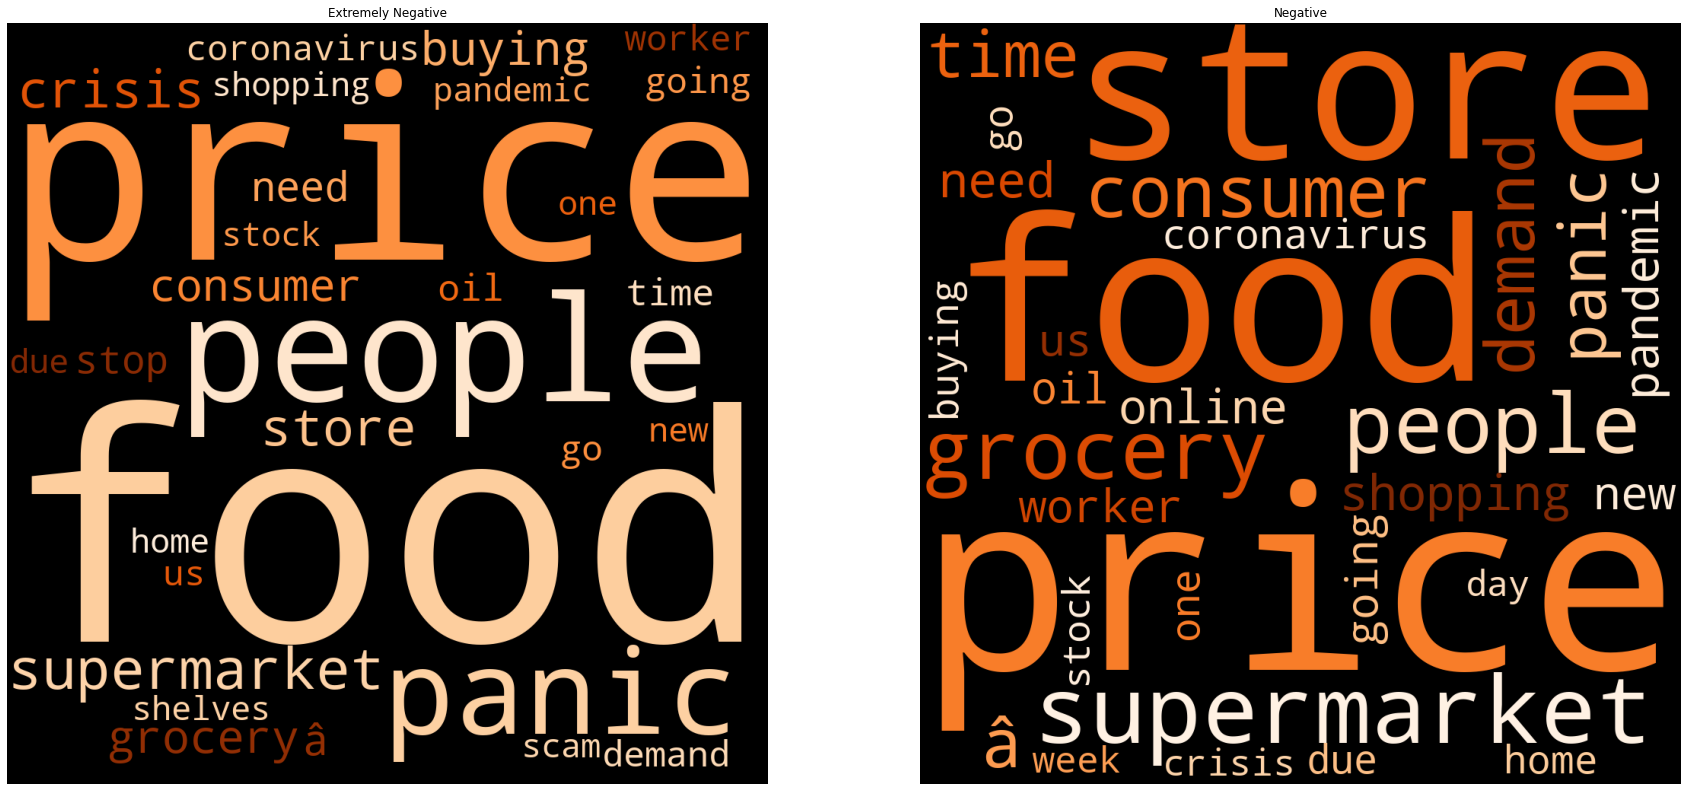

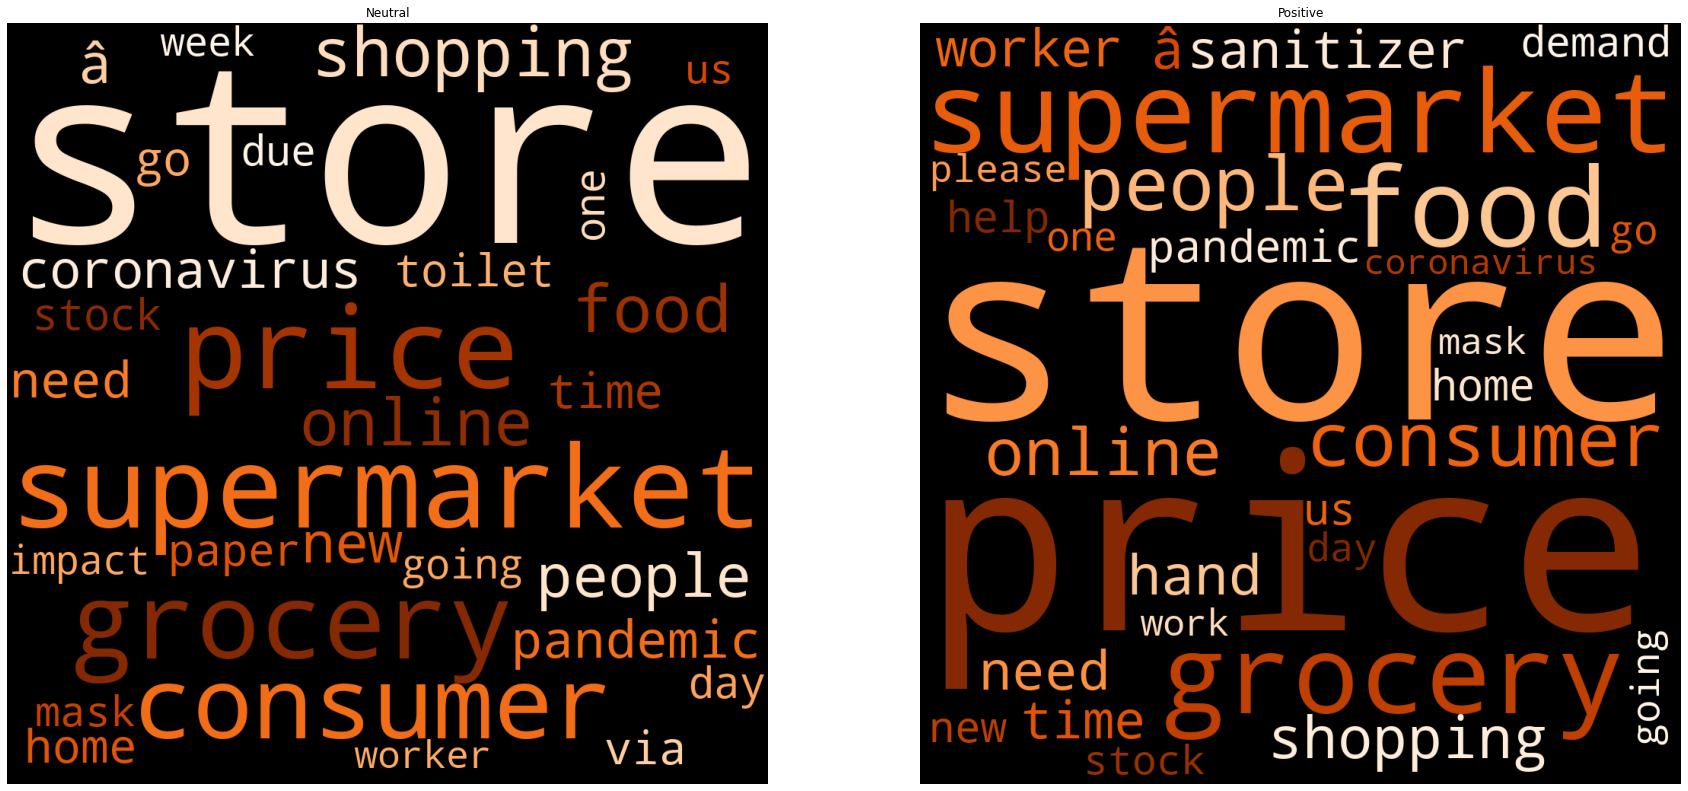

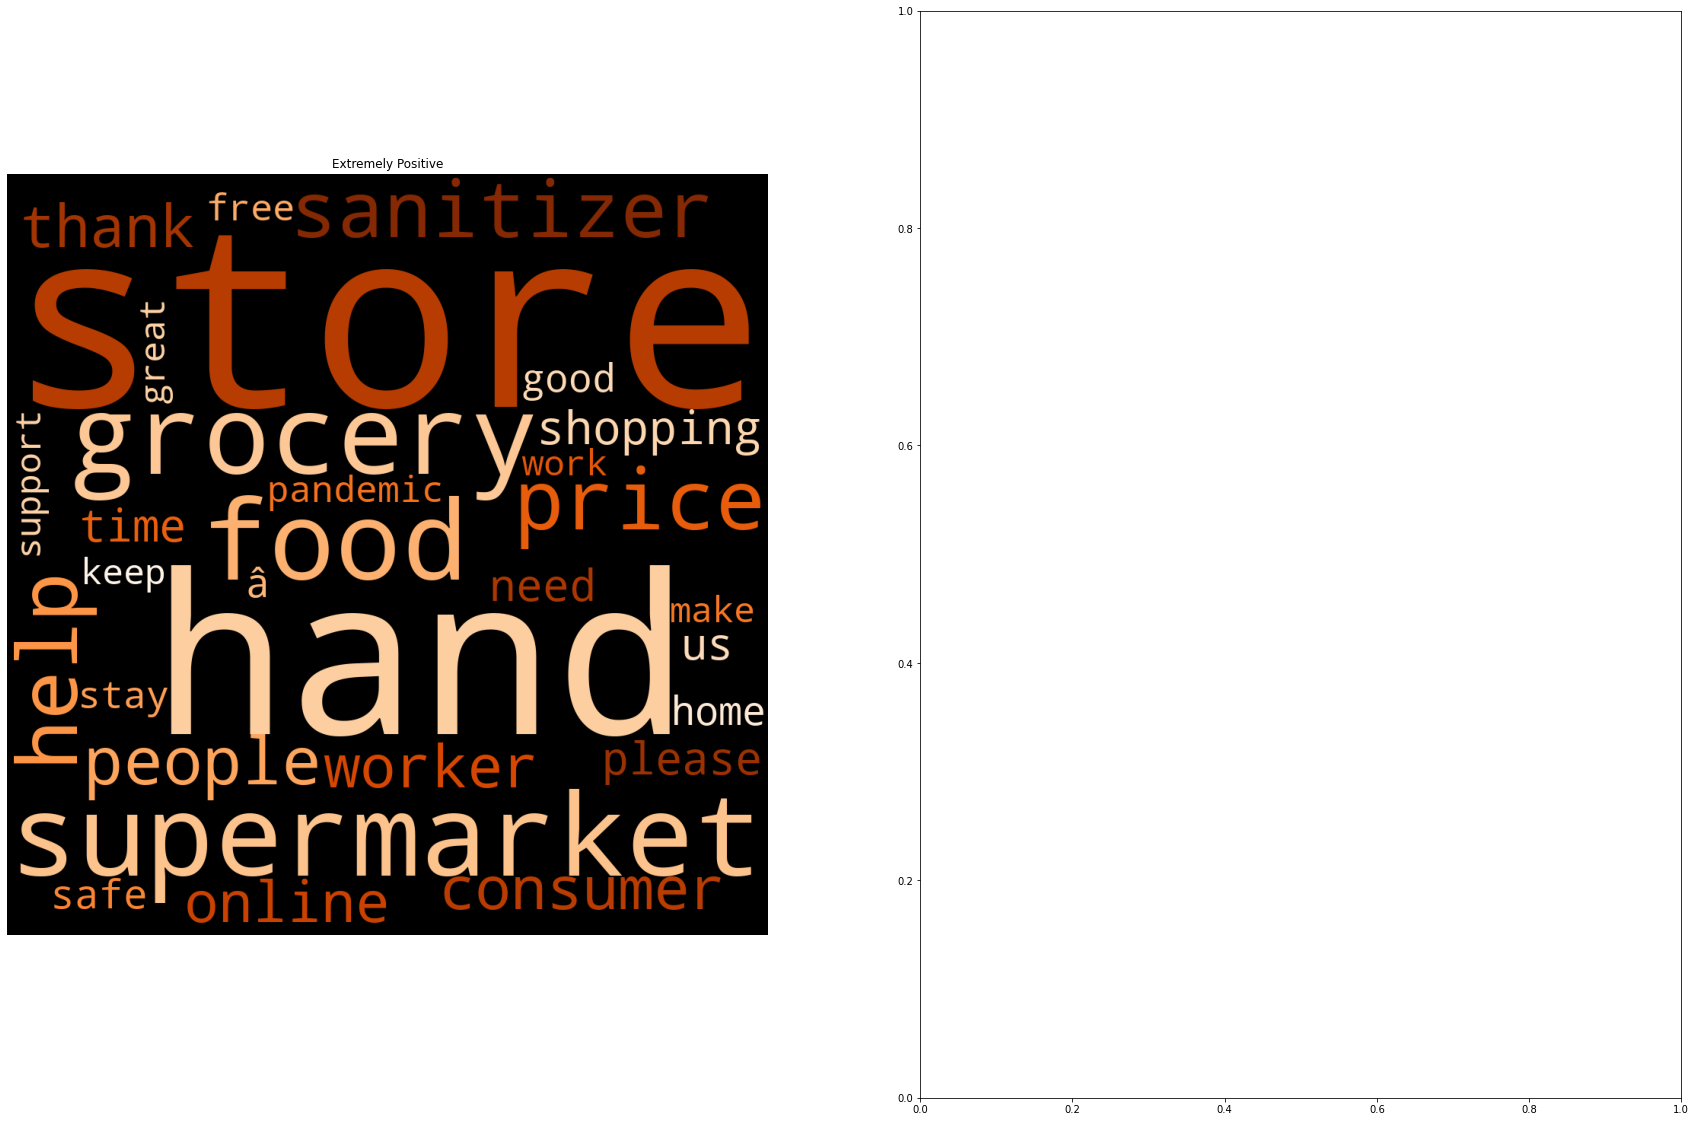

In [50]:
text_sentimento = {}
for sentimento in labels_dict:
    text_sentimento[sentimento] = " ".join([token for index, f_token in enumerate(feature_tokens) if labels[index] == labels_dict[sentimento] for token in f_token ])  
monta_wordcloud(labels_dict, text_sentimento)

### Word Cloud por Trending/Sentimento

In [ ]:
_count_trends = Counter()
_count_trends.update([token for index, lista_token in enumerate(X_tokens + X_tokens_verificar) if y[index] == sentimento for token in lista_token if re.match(r'#\w+',token) ])
monta_wordcloud(lista_sentimentos, _count_trends, generate_from_text=False)


### Word Cloud palavras não Encontradas (Sem Trending)

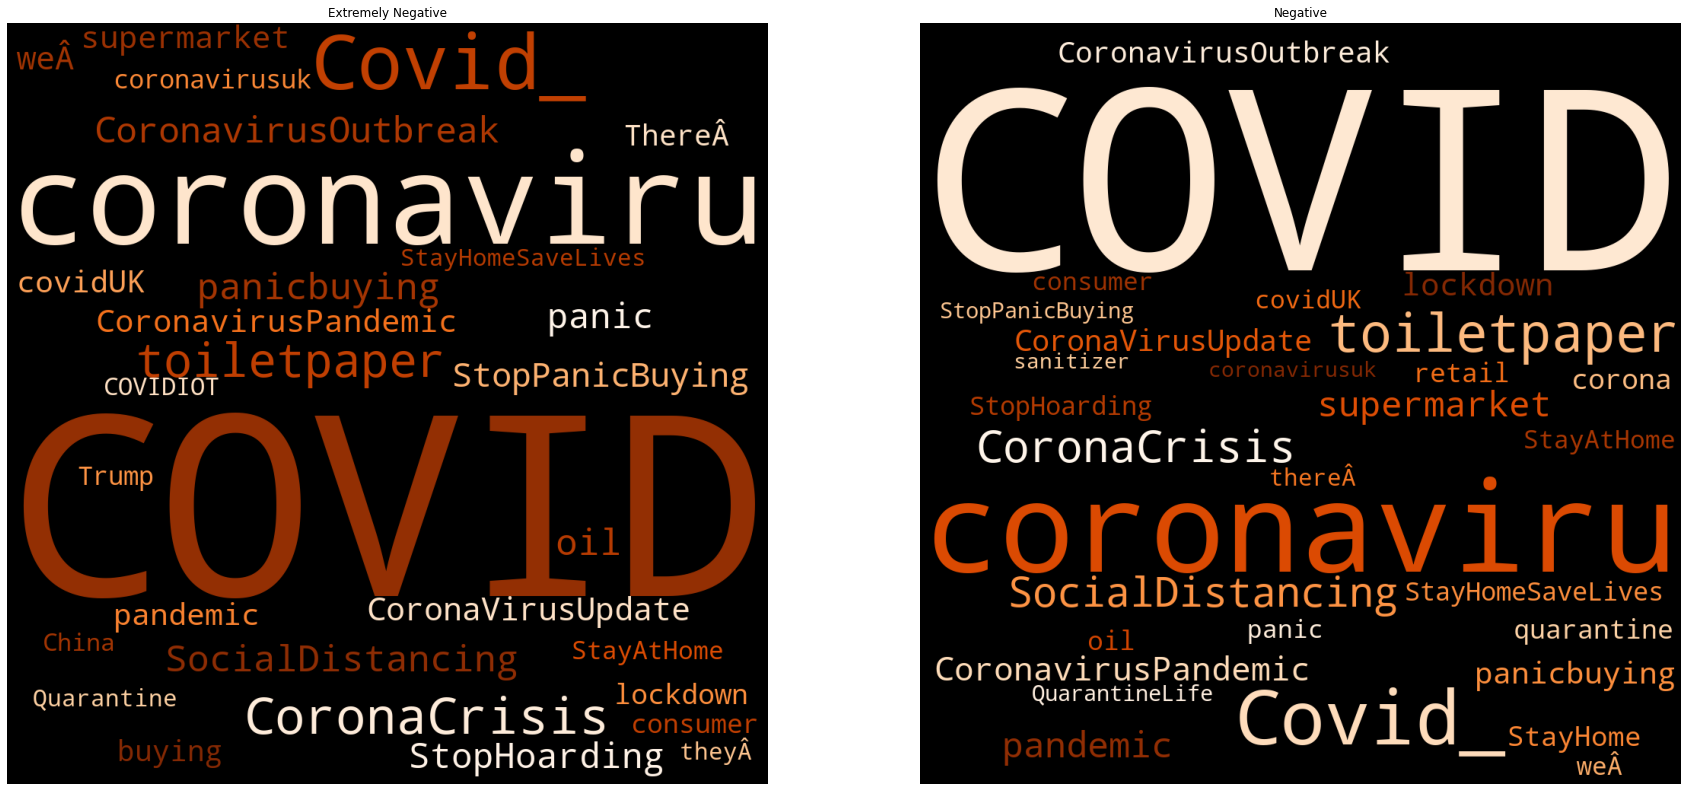

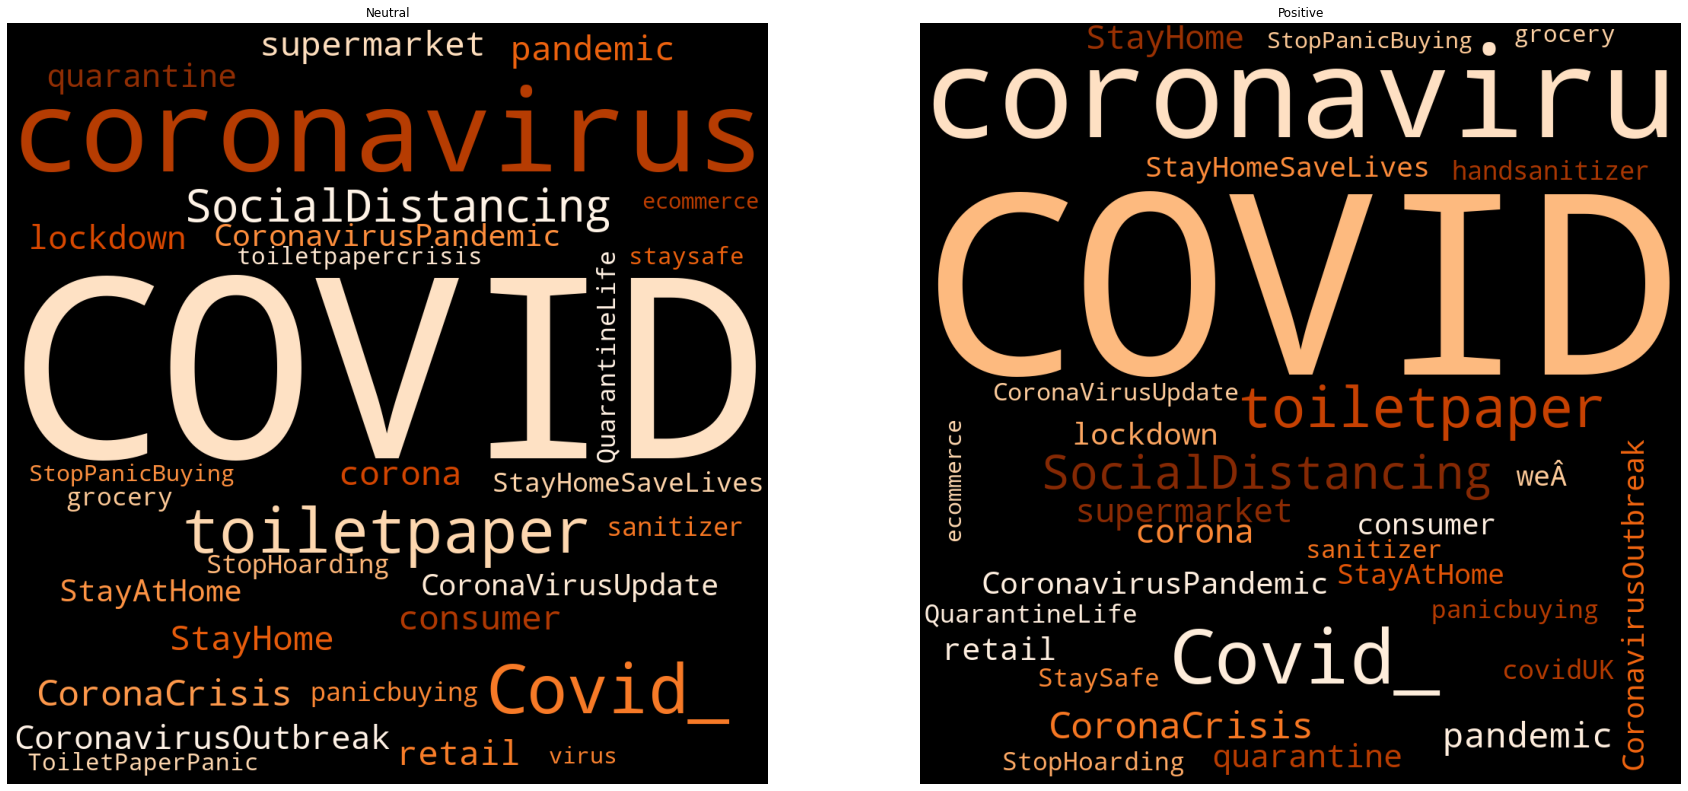

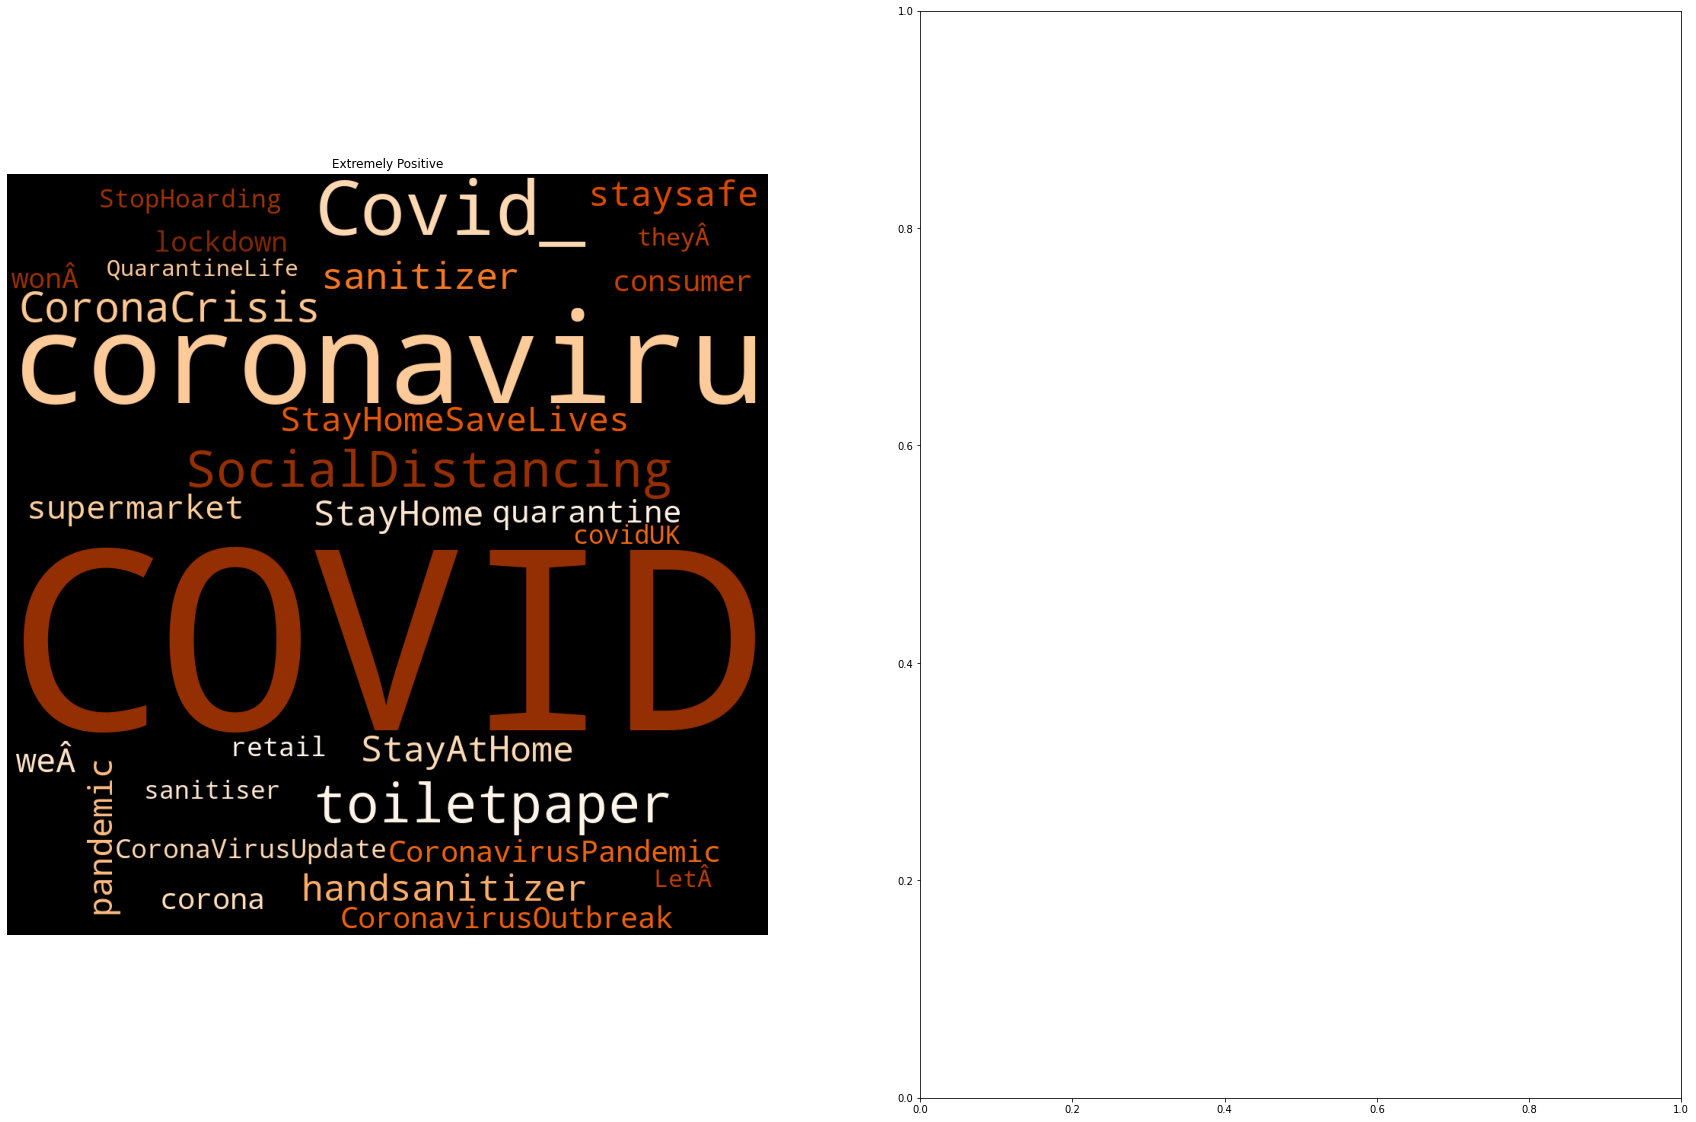

In [53]:
text_sentimento = {}
for sentimento in labels_dict:
    text_sentimento[sentimento] = " ".join([token for index, f_token in enumerate(feature_tokens_verificar) if labels[index] == labels_dict[sentimento] for token in f_token ])  
monta_wordcloud(labels_dict, text_sentimento)



## Modelos

### LSTM

In [26]:
def create_model_LSTM(weight_matrix, dim_embedding, max_words_length):
    model = Sequential()
    model.add(Embedding(len(weight_matrix), dim_embedding, weights=[weight_matrix], input_length=max_words_length, trainable=False))
    # model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.50))
    model.add(Dense(5, activation='softmax'))
    # Adam Optimiser
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    
    return model

# Execução

In [23]:
# Converter tokens para a representação word vec
def convert_feature_tokens_to_word_vec(feature_tokens,  vocab, dimension_size=100, max_word_length=50):
    feature_word_vec = np.zeros((len(feature_tokens), max_word_length), dtype='int32')
    for c_feature, f_token in enumerate(feature_tokens):
        for c_token,token in enumerate(f_token):
            feature_word_vec[c_feature,c_token] = vocab[token]
        
    return feature_word_vec
    

In [ ]:
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
<ipython-input-15-51120598aa9b> in <module>
      1 max_word_length=80
----> 2 X_train = convert_feature_tokens_to_word_vec(X_train, vocab,max_word_length=max_word_length)
      3 model = create_model_LSTM(embedding, 100, max_word_length)
      4 model.fit(X_train, y_train, batch_size=2000, epochs=100)

<ipython-input-12-d63fb2b2f168> in convert_feature_tokens_to_word_vec(feature_tokens, vocab, dimension_size, max_word_length)
      4     for c_feature, f_token in enumerate(feature_tokens):
      5         for c_token,token in enumerate(f_token):
----> 6             feature_word_vec[c_feature,c_token] = vocab[token]
      7 
      8     return feature_word_vec

KeyError: 66803

In [8]:
def executa_desafio(tipo_modelo):
    
    vocab, embedding, feature_tokens_train, labels_train, feature_tokens_validation, labels_validation,  labels_dict = monta_estrutura_execucao_rnn()
    
    y_train = convert_labels_to_hot_encode(labels_train, labels_dict)
    X_train = convert_feature_tokens_to_word_vec(feature_tokens_train, vocab)
    
    y_validation = convert_labels_to_hot_encode(labels_validation, labels_dict)
    X_validation = convert_feature_tokens_to_word_vec(feature_tokens_validation, vocab)
    
    if tipo_modelo == 'LSTM':
        model = create_model_LSTM(embedding, 100, 50)
        model.fit(train_X, train_y, validation_data = (X_val, y_val), batch_size=2000, epochs=100)
    
    

In [ ]:
max_word_length=80

dados = pd.read_csv('Corona_NLP_train.csv', engine="python")

(vocab, embedding), (feature_tokens, feature_tokens_verificar) , labels, labels_dict = pre_processamento_word_vec(dados, 
                                                                                                                  glove_twitter=True, 
                                                                                                                  convert_labels_hot_encode=True,
                                                                                                                  min_length_word=1,
                                                                                                                  use_lemmatizer=False,
                                                                                                                  use_twitter_tokenizer=True)

X_train, X_val, y_train, y_val = train_test_split(feature_tokens, labels,  test_size=0.2, random_state=0)

X_train = convert_feature_tokens_to_word_vec(X_train, vocab,max_word_length=max_word_length)
X_validation = convert_feature_tokens_to_word_vec(X_val, vocab, max_word_length=max_word_length)

model = create_model_LSTM(embedding, 100, max_word_length)
model.fit(X_train, y_train, batch_size=2000, epochs=100)

In [ ]:
max_word_length=80
#X_train, X_val, y_train, y_val = train_test_split(feature_tokens, labels,  test_size=0.2, random_state=0)

#X_train = convert_feature_tokens_to_word_vec(X_train, vocab, max_word_length=max_word_length)
#X_validation = convert_feature_tokens_to_word_vec(X_val, vocab, max_word_length=max_word_length)

X_train = convert_feature_tokens_to_word_vec(feature_tokens, vocab, max_word_length=max_word_length)


model = create_model_LSTM(embedding, 100, max_word_length)
model.fit(X_train, y_train, validation_split=0.2, batch_size=2000, epochs=100)

Epoch 1/100
